In [1]:
%matplotlib notebook
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

sns.set_style('darkgrid')
np.random.seed(42)

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('./radon.csv', index_col=[0])
df.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,5081.0,MN,MN,27.0,55735,5.0,1.0,1.0,3.0,N,...,9.7,1146.499190,1.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
1,5082.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,14.5,471.366223,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
2,5083.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,9.6,433.316718,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,1.098612
3,5084.0,MN,MN,27.0,56469,5.0,1.0,0.0,4.0,Y,...,24.3,461.623670,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.095310
4,5085.0,MN,MN,27.0,55011,3.0,1.0,0.0,4.0,Y,...,13.8,433.316718,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,1.163151


<IPython.core.display.Javascript object>


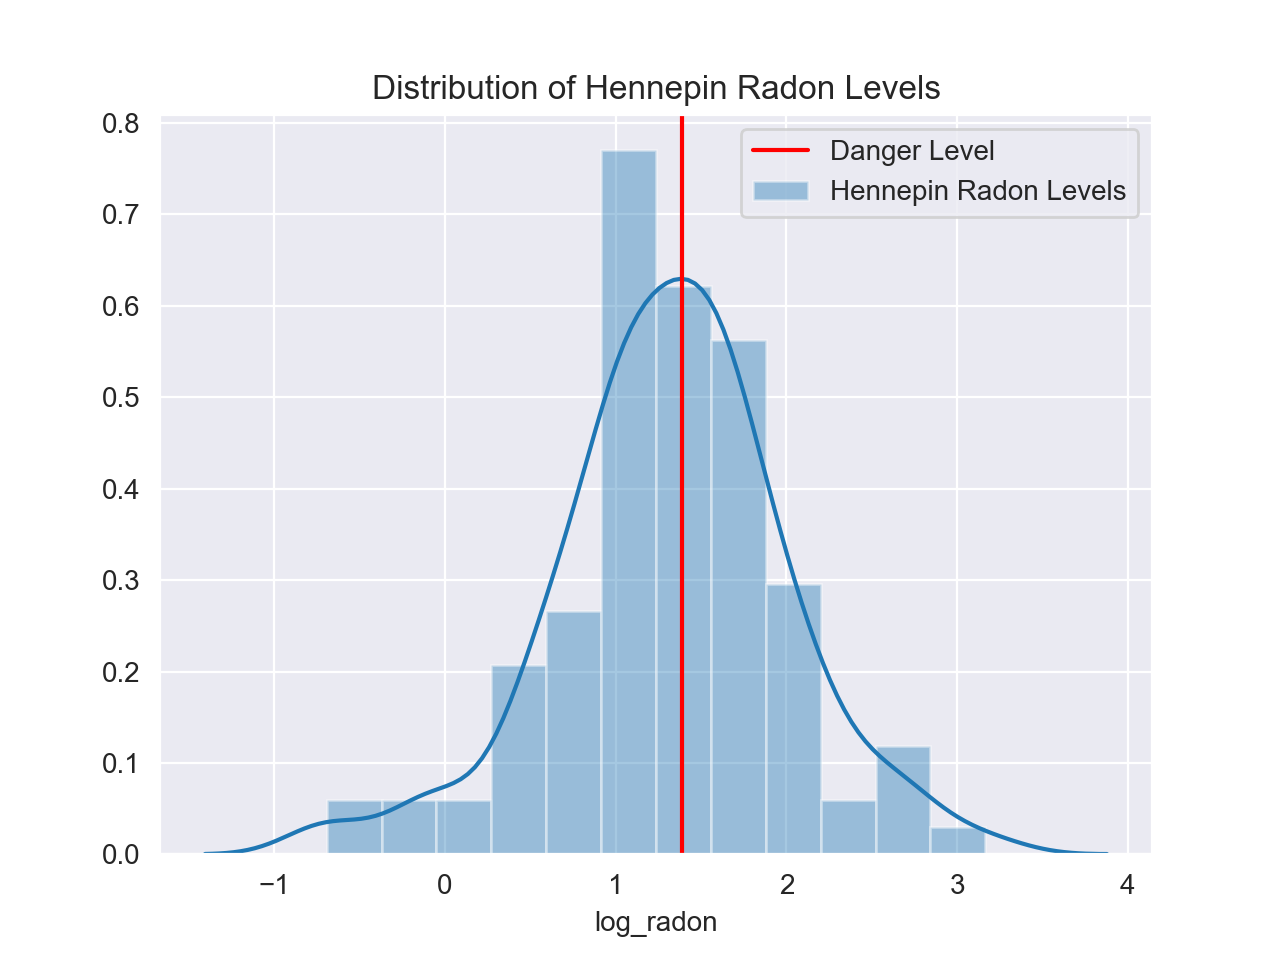

In [3]:
fig, ax = plt.subplots(1, 1)
sns.distplot(df[df['county'] == 'HENNEPIN']['log_radon'], 
             label='Hennepin Radon Levels', 
             ax=ax)
ax.axvline(np.log(4), c='r', label='Danger Level')
ax.set_title('Distribution of Hennepin Radon Levels')
ax.legend()
plt.show();

### Priors 
$$
p(\theta=\mu, \sigma)
$$

In [4]:
with pm.Model() as radon_model:
    μ = pm.Normal('μ', mu=0, sigma=10)
    σ = pm.Uniform('σ', 0, 10)

### Likelihood 
$$
p(Data \vert \theta=\mu, \sigma)
$$

In [5]:
with radon_model:
    likelihood = pm.Normal('likelihood', mu=μ, sigma=σ, observed=df[df['county'] == 'HENNEPIN']['log_radon'])

### Sampling Posterior with MCMC 
$$
\begin{aligned}
p(\theta=\mu, \sigma \vert Data) &= \frac{p(Data \vert \theta=\mu, \sigma)p(\theta=\mu, \sigma)}{p(Data)}
\end{aligned}
$$

In [6]:
with radon_model:
    samples = pm.sample(1000, tune=1000, cores=2, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 3880.87draws/s]


<IPython.core.display.Javascript object>


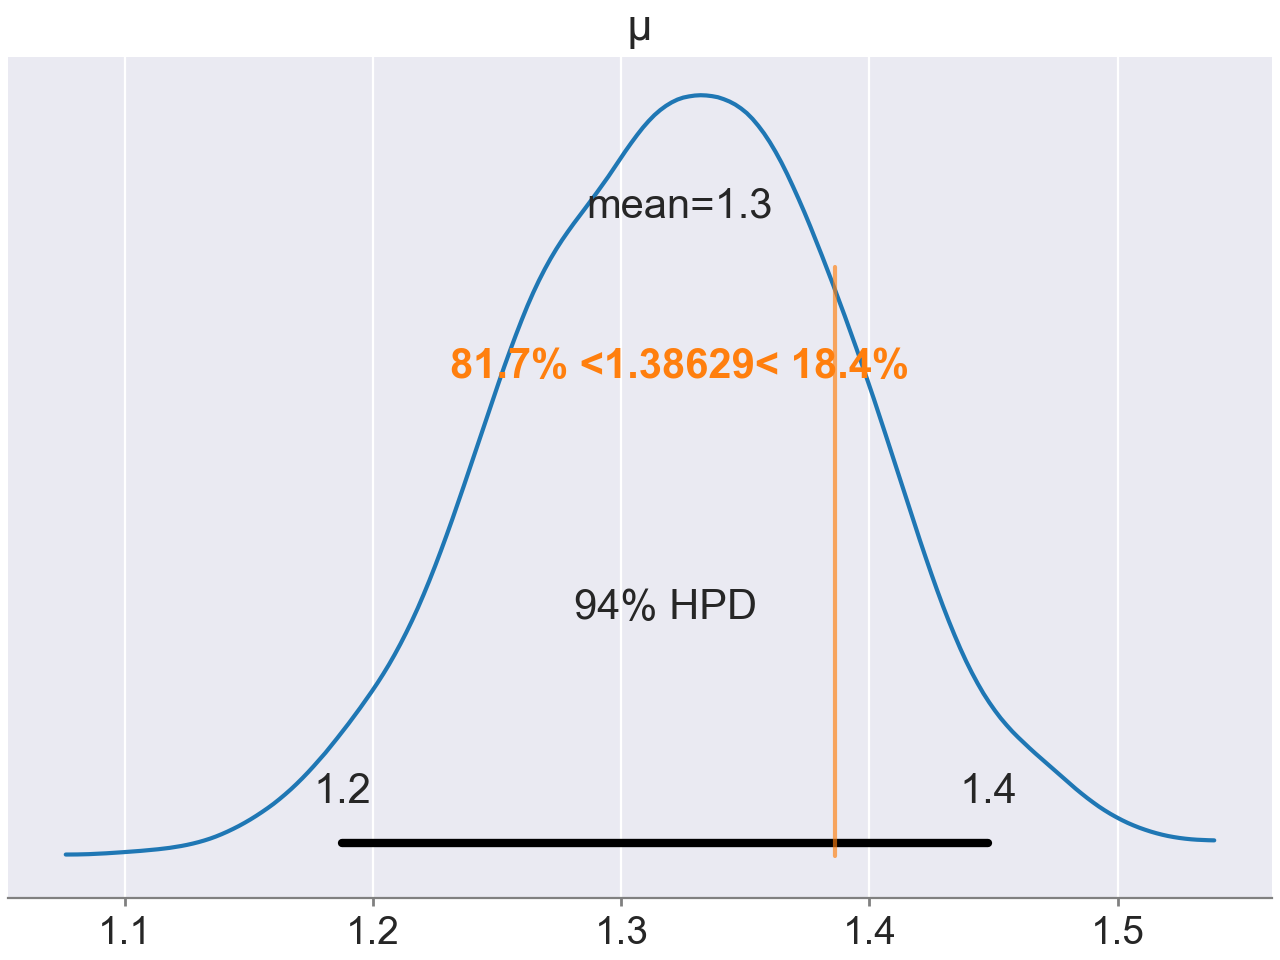

In [7]:
from arviz import plot_posterior

plot_posterior(samples, var_names=['μ'], ref_val=np.log(4));

### Sampling Posterior Predictive 

$$
\begin{aligned}
p(New\,Data = Z \vert Data = X) &= \int_\theta{p(Z\vert\theta)p(\theta\vert X)}d\theta
\end{aligned}
$$

This is approximated by:

```python

for i in range(1, n_samples_to_draw_from_posterior_predictive):
    
    # Step 1: Sample θ_i from the posterior distribution 
    # that we've found via MCMC
    θ_i ~ p(θ|X)
    
    # Step 2: Sample New data Z from likelihood function
    # using θ_i sampled
    Z ~ p(X|θ_i)

```

In [8]:
with radon_model:
    pp_samples = pm.sample_posterior_predictive(samples, 1000)

100%|██████████| 1000/1000 [00:00<00:00, 1464.88it/s]


In [9]:
print(f'''Posterior probability that a randomly-selected 
    household in Hennepin County contains radon levels 
    in excess of 4 pCi/L ~ {round((pp_samples['likelihood'] > np.log(4)).mean(), 2)}''')

Posterior probability that a randomly-selected 
    household in Hennepin County contains radon levels 
    in excess of 4 pCi/L ~ 0.46


### Model Checks

In order to check the goodness of fit of our model, we have to simulate data from the posterior predictive, and choose a particular statistic to check. We will compare the proportion of samples drawn from the posterior predictive distribution and the original data distribution with `> np.log(4)` radon levels.

<IPython.core.display.Javascript object>


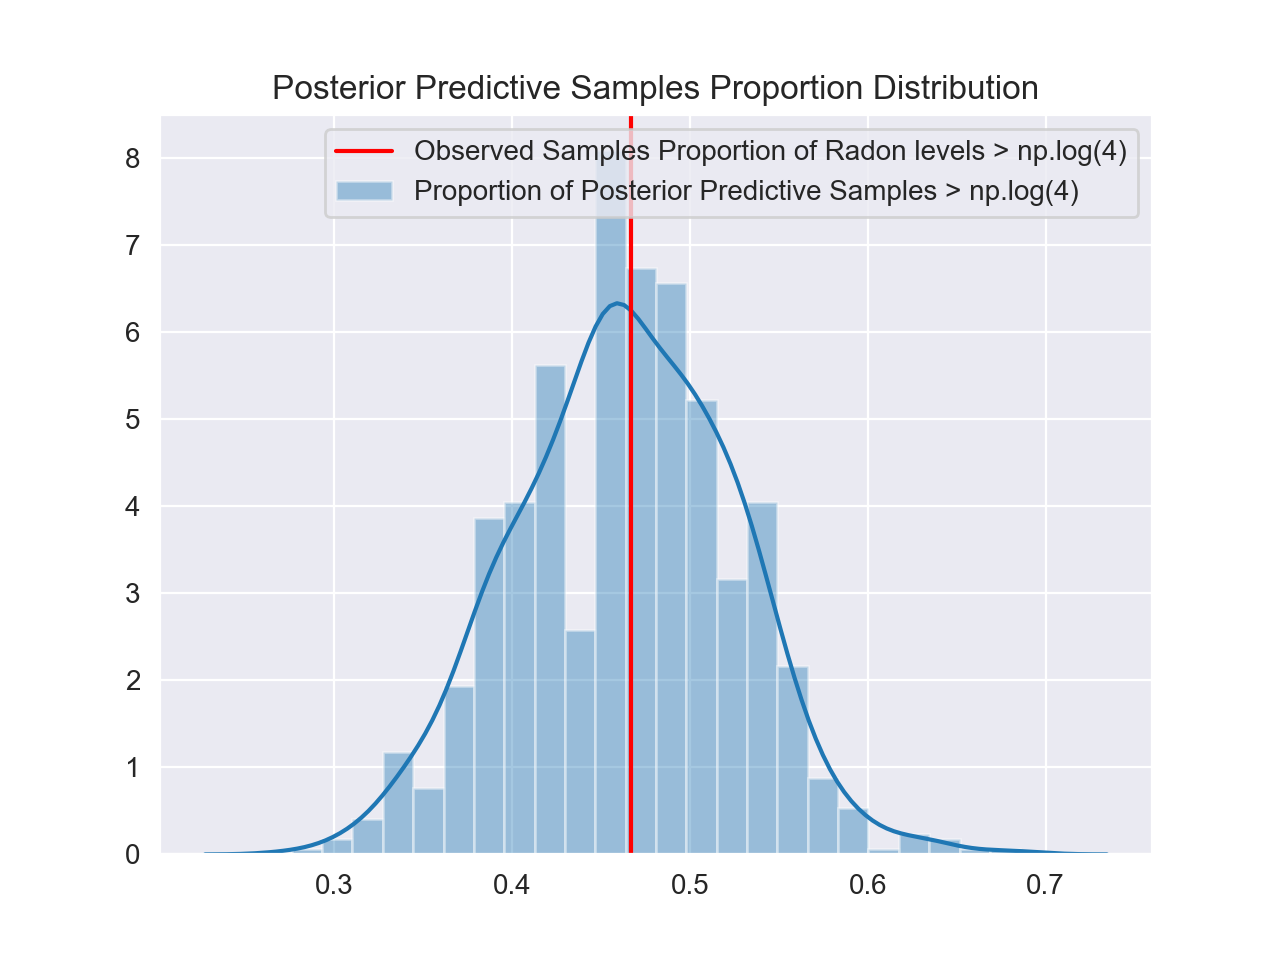

In [17]:
fig, ax = plt.subplots(1, 1)

# Posterior Predictive Samples Proportion Distribution
sns.distplot((pp_samples['likelihood'] > np.log(4)).mean(axis=1), 
             label=f'''Proportion of Posterior Predictive Samples > np.log(4)''', 
             ax=ax)

# Observed Samples Proportion of Radon levels > np.log(4)
ax.axvline((df[df['county'] == 'HENNEPIN']['log_radon'] > np.log(4)).mean(),
           c='r', 
           label='Observed Samples Proportion of Radon levels > np.log(4)')

ax.set_title('Posterior Predictive Samples Proportion Distribution')
ax.legend()
plt.show();

### Prior Sensitivity

### Resources
- [Probability that any randomly-chosen household in Hennepin county has a reading > 4](https://github.com/fonnesbeck/mcmc_pydata_london_2019/blob/master/notebooks/1-Introduction_to_PyMC3.ipynb)
- [Modeling radon levels in Minnesota](https://docs.pymc.io/notebooks/multilevel_modeling.html)